In [2]:
!pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 12.8 MB/s 


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [5]:
import pandas as pd

df = pd.read_csv("/content/sms_spam.csv")
df.head(5)

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.groupby('type').describe()

text                                                               
     count unique                                                top freq
type                                                                     
ham   4827   4518                             Sorry, I'll call later   30
spam   747    642  Please call our customer service representativ...    4

In [7]:
df['type'].value_counts() 

ham     4827
spam     747
Name: type, dtype: int64

In [11]:
747/4827 # so 15% of samples are spam that indicates imbalance dataset as ham are 85%

0.15475450590428838

In [10]:
# now, lets do downsampling for balancing the dataset. means out of 4827 ham messages just pick randomly 747 messages
# in order to get counts equal for both ham and spam

In [12]:
df_spam = df[df['type']=='spam']
df_spam.shape

(747, 2)

In [14]:
df_ham = df[df['type']=='ham']
df_ham.shape

(4827, 2)

In [15]:
#Here we are taking only 747 samples randomly from df_ham for downsampling
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [16]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [17]:
df_balanced['type'].value_counts()

spam    747
ham     747
Name: type, dtype: int64

In [18]:
df_balanced['spam']=df_balanced['type'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,type,text,spam
3133,ham,I've been barred from all B and Q stores for l...,0
962,spam,URGENT! We are trying to contact U. Todays dra...,1
4864,spam,Bored housewives! Chat n date now! 0871750.77....,1
2740,ham,Are you this much buzy,0
4313,ham,I keep ten rs in my shelf:) buy two egg.,0


In [19]:
# Split it into training and test data set

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['text'],df_balanced['spam'], stratify=df_balanced['spam'])

In [ ]:
# above we used stratify in order to make sure the spam column distribution must be equal

In [21]:
X_train.head(5)

5377    I cant pick the phone right now. Pls send a me...
5366    Call 09095350301 and send our girls into eroti...
2189    FREE camera phones with linerental from 4.49/m...
2418    Oh... Lk tt den we take e one tt ends at cine ...
83                   You will be in the place of that man
Name: text, dtype: object

In [22]:
# Now lets import BERT model and get embeding vectors for few sample statements

In [23]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [24]:
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [26]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "1000$ discount. hurry up", 
    "Ravi, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.85046005, -0.51658034, -0.9307087 , ..., -0.826726  ,
        -0.7626386 ,  0.9219374 ],
       [-0.8848379 , -0.5399184 , -0.9443212 , ..., -0.87659824,
        -0.742864  ,  0.9029491 ]], dtype=float32)>

In [27]:
# Get embeding vectors for few sample words. Compare them using cosine similarity

In [30]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [32]:
e[0].shape

TensorShape([768])

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911089]], dtype=float32)

In [34]:
# Values near to 1 means they are similar. 0 means they are very different. Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [36]:
cosine_similarity([e[0]],[e[4]])

array([[0.8933628]], dtype=float32)

In [37]:
cosine_similarity([e[3]],[e[4]])

array([[0.98720354]], dtype=float32)

In [38]:
cosine_similarity([e[0]],[e[4]])

array([[0.8933628]], dtype=float32)

In [39]:
# Build Model
# There are two types of models you can build in tensorflow.

# (1) Sequential (2) Functional

In [40]:
# Ref: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [41]:
# Let's build Functional Model

In [42]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [44]:
len(X_train)

1120

In [45]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [46]:
# Train the model

In [48]:
model.fit(X_train, y_train, epochs=1)

35/35 [==============================] - 481s 14s/step - loss: 0.5788 - accuracy: 0.6955 - precision: 0.6898 - recall: 0.7107


In [49]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 162s 13s/step - loss: 0.5113 - accuracy: 0.8556 - precision: 0.8244 - recall: 0.9037


[0.5112914443016052, 0.855614960193634, 0.8243902325630188, 0.903743326663971]

In [50]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [51]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,

In [52]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[151,  36],
       [ 18, 169]])

Text(33.0, 0.5, 'Truth')

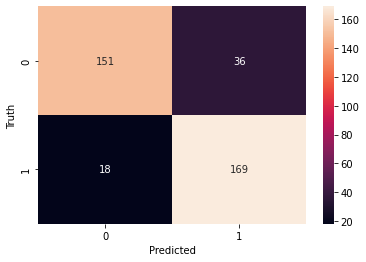

In [53]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [54]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85       187
           1       0.82      0.90      0.86       187

    accuracy                           0.86       374
   macro avg       0.86      0.86      0.86       374
weighted avg       0.86      0.86      0.86       374



In [55]:
# Inference

In [56]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.6012558 ],
       [0.6201738 ],
       [0.58930784],
       [0.40700722],
       [0.34476638]], dtype=float32)

In [61]:
reviews = [
    "I HAVE A DATE ON SUNDAY WITH WILL!!",
    "congratulations!! you won 1000$ as reward ",
    "WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only."
]
model.predict(reviews)

array([[0.23127931],
       [0.27607298],
       [0.69116014]], dtype=float32)